<h2>Identifying the Best Option Price Model for each Firm<h2>

The goal of the project is to determine for each firm, which model would best approximate the option price. 

Here is the structure of the code:

We look at the firms from $faangTickers$.

We also pre-determined a list of features that is of our interest

We go through each of firm in $faangTickers$. Before computing the MSE, we use TimeSeriesSplit to split the data chronically according to the dates towards expiration (it only makes sense to use the data of the options that expire recently to predict behavior of the options expires in the future).

Now we loop through each power set of features. After splitting, we train the data using the models from the models_list, and compute their respective mse for each split, and records them in rmses. $rmses$ is a 2-d table, rows corresponds to different models, columns corresponds to the splits for each subset of features (1-5).

Then by taking the average across all splits for each feature, we produce $amses$, whose rows corresponds to different models, and columns corresponds to the average mse of each feature.

And finally, by referring to $amses$, we check which set of features and models performs the best for each firm.

We first import all the packages


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
import logging
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import ipywidgets as widgets
from IPython.display import display


In [9]:
## For readability, we disallow certain features
## block the error messaging
logging.getLogger("yfinance").setLevel(logging.CRITICAL)
pd.options.mode.chained_assignment = None

In [10]:
# ## Fetch all the necessary data
# # Define FAANG tickers and names
# faang_tickers = {
#     "META": "Meta (Facebook)",
#     "AAPL": "Apple",
#     "AMZN": "Amazon",
#     "NFLX": "Netflix",
#     "GOOGL": "Google"}

# # Container for all data
# all_faang_options = []

# # Loop through each FAANG company
# for symbol, name in faang_tickers.items():
#     print(f"Fetching options for {name} ({symbol})...")
#     ticker = yf.Ticker(symbol)

#     expirations = ticker.options

#     for i, expiration in enumerate(expirations):
#         try:
#             option_chain = ticker.option_chain(expiration)

#             # Process calls and puts
#             for df, opt_type in [(option_chain.calls, 'call'), (option_chain.puts, 'put')]:
#                 df = df.copy()
#                 df['expiration'] = expiration
#                 df['option_type'] = opt_type
#                 df['ticker'] = symbol
#                 all_faang_options.append(df)

#             print(f"  - [{i+1}/{len(expirations)}] {expiration} OK")
#             #time.sleep(1)

#         except Exception as e:
#             print(f"  - Failed for {expiration}: {e}")

# # Combine all FAANG options into a single DataFrame
# faang_df = pd.concat(all_faang_options, ignore_index=True)

# Full path to the FAANG_data.csv file
file_path = "/Users/zouruiqi2020/Downloads/data-science-summer-2025-main/My Project/Data Collection/FAANG_data/FAANG_data.csv"

# Read the CSV into a DataFrame
faang_df = pd.read_csv(file_path)

print(faang_df.head())

# drop empty values
faang_df_clean = faang_df.dropna(subset=[
    'lastPrice', 'impliedVolatility', 'strike', 'bid', 'ask', 'openInterest'
])
# clean unreasonable data
faang_df_clean = faang_df_clean[
    (faang_df_clean['lastPrice'] > 0) &
    (faang_df_clean['impliedVolatility'] > 0) &
    (faang_df_clean['bid'] >= 0) &
    (faang_df_clean['ask'] >= 0) &
    (faang_df_clean['openInterest'] > 0)
]
faang_df_clean['midPrice'] = (faang_df_clean['bid'] + faang_df_clean['ask']) / 2
spread = faang_df_clean['ask'] - faang_df_clean['bid']
faang_df_clean['ask_bid_spread']=spread
faang_df_clean = faang_df_clean[spread / faang_df_clean['midPrice'] < 0.5]

# Time to maturity in years
faang_df_clean['expiration'] = pd.to_datetime(faang_df_clean['expirationDate'])
faang_df_clean['days_to_exp'] = (faang_df_clean['expiration'] - datetime.today()).dt.days
faang_df_clean = faang_df_clean[faang_df_clean['days_to_exp'] > 0]
faang_df_clean['T'] = faang_df_clean['days_to_exp'] / 365

# Fetch spot prices for each ticker (if needed)
spot_prices = {ticker: yf.Ticker(ticker).history(period='1d')['Close'].iloc[-1]
            for ticker in faang_df_clean['ticker'].unique()}

faang_df_clean['spot'] = faang_df_clean['ticker'].map(spot_prices)

# Moneyness
faang_df_clean['moneyness'] = faang_df_clean['spot'] / faang_df_clean['strike']


faang_df_clean = faang_df_clean[
    (faang_df_clean['moneyness'] > 0.8) & (faang_df_clean['moneyness'] < 1.2) &
    (faang_df_clean['T'] > 1/365)  # > 1 day to maturity
]
faang_df_clean['log_moneyness']=np.log(faang_df_clean['moneyness'] )


#Black-Schole Price

def black_scholes_price(S, K, T, r, sigma, option_type):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan  # skip invalid inputs

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        return np.nan
risk_free_rate = 0.0433
faang_df_clean['bs_price'] = faang_df_clean.apply(
    lambda row: black_scholes_price(
        S=row['spot'],
        K=row['strike'],
        T=row['T'],
        r=risk_free_rate,
        sigma=row['impliedVolatility'],
        option_type=row['optionType']
    ),
    axis=1
)

faang_df_clean.sample(10)

        contractSymbol              lastTradeDate  strike  lastPrice    bid  \
0  GOOG250627C00085000  2025-06-20 16:26:07+00:00    85.0      86.50  79.10   
1  GOOG250627C00095000  2025-06-06 13:42:13+00:00    95.0      78.10  69.10   
2  GOOG250627C00100000  2025-06-23 19:48:05+00:00   100.0      65.47  64.10   
3  GOOG250627C00105000  2025-05-21 13:58:00+00:00   105.0      64.55  65.75   
4  GOOG250627C00120000  2025-05-21 17:11:20+00:00   120.0      52.79  45.95   

     ask    change  percentChange  volume  openInterest  impliedVolatility  \
0  82.50  0.000000       0.000000     1.0           1.0           3.791993   
1  72.35  0.000000       0.000000     1.0           1.0           3.172854   
2  67.10 -4.629997      -6.604846    48.0          23.0           2.793948   
3  68.55  0.000000       0.000000     NaN           1.0           4.227544   
4  49.50  0.000000       0.000000     5.0           8.0           2.174809   

   inTheMoney contractSize currency optionType expiratio

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,ticker,midPrice,ask_bid_spread,expiration,days_to_exp,T,spot,moneyness,log_moneyness,bs_price
3636,AAPL250815P00215000,2025-06-23 19:59:36+00:00,215.0,15.95,15.90,16.15,-2.950000,-15.608464,168.0,3779.0,...,AAPL,16.025,0.25,2025-08-15,52,0.142466,201.500000,0.937209,-0.064849,15.027306
756,GOOG260116C00185000,2025-06-23 19:35:42+00:00,185.0,9.50,9.50,9.60,-1.100000,-10.377361,355.0,6285.0,...,GOOG,9.550,0.10,2026-01-16,206,0.564384,166.009995,0.897351,-0.108308,10.882014
5301,META250627P00617500,2025-06-23 18:07:07+00:00,617.5,0.12,0.08,0.12,-0.480000,-80.000000,55.0,22.0,...,META,0.100,0.04,2025-06-27,3,0.008219,698.530029,1.131223,0.123299,0.010199
6712,META250919C00860000,2025-06-23 16:04:10+00:00,860.0,5.45,5.85,6.00,0.350000,6.862744,1.0,463.0,...,META,5.925,0.15,2025-09-19,87,0.238356,698.530029,0.812244,-0.207954,6.545119
10331,NFLX250718P01300000,2025-06-23 19:58:45+00:00,1300.0,82.23,81.20,85.65,-6.339996,-7.158176,9.0,67.0,...,NFLX,83.425,4.45,2025-07-18,24,0.065753,1253.540039,0.964262,-0.036393,81.058268
4557,AAPL260918C00175000,2025-06-20 16:24:22+00:00,175.0,45.19,45.75,46.20,0.989998,2.239814,6.0,29.0,...,AAPL,45.975,0.45,2026-09-18,451,1.235616,201.500000,1.151429,0.141003,51.376641
9571,NFLX250627P01140000,2025-06-23 19:51:40+00:00,1140.0,0.27,0.22,0.35,-0.630000,-70.786514,216.0,244.0,...,NFLX,0.285,0.13,2025-06-27,3,0.008219,1253.540039,1.099597,0.094943,0.041330
1204,GOOG270617C00185000,2025-06-23 18:40:04+00:00,185.0,26.40,26.90,27.45,-3.600000,-12.000001,1.0,160.0,...,GOOG,27.175,0.55,2027-06-17,723,1.980822,166.009995,0.897351,-0.108308,32.702883
1109,GOOG270115C00145000,2025-06-23 16:02:13+00:00,145.0,42.50,42.40,42.85,-2.259998,-5.049148,1.0,145.0,...,GOOG,42.625,0.45,2027-01-15,570,1.561644,166.009995,1.144897,0.135314,47.819787
10425,NFLX250725C01445000,2025-06-12 15:07:09+00:00,1445.0,11.59,10.05,11.35,0.000000,0.000000,NaN,10.0,...,NFLX,10.700,1.30,2025-07-25,31,0.084932,1253.540039,0.867502,-0.142138,10.857625


🟦 Definitions:

LastPrice is the most recent transaction price of an option, reflecting real market behavior.


Black-Scholes Price is a theoretical value based on assumptions such as constant volatility, no arbitrage, and frictionless markets.


🟨 Why use the Black-Scholes model?
We use Black-Scholes as a baseline to estimate what the option should be worth under idealized conditions. Comparing this theoretical price to the observed lastPrice helps us identify deviations that may be due to market sentiment, liquidity constraints, or mispricing.


🟩 What are we trying to do?
Our objective is to develop a model that accurately predicts lastPrice. While Black-Scholes provides a clean theoretical benchmark, it doesn’t fully capture the complexities of real markets. By modeling lastPrice, we aim to better understand and anticipate how options are actually priced in practice—accounting for behaviors, frictions, and nonlinearities beyond the scope of traditional theory.


Here is where we keep all the candidate features for linear regressions, and the list of other models that we'd like to use to compare and determine the best model.

#Constants here needs to be modified if more features and models needs to be added

In [11]:
#attempt to improve the black-scholes model by adding in the following variables
candidate_list = ['bs_price', 'impliedVolatility', 'log_moneyness', 'ask_bid_spread']

#code that generate all powerset of candidate list
select = [[1], [0]]
for i in range(len(candidate_list)-1):
    select_new = []
    for j in select:
        j_0 = j.copy()
        j_0.append(0)
        j_1 = j.copy()
        j_1.append(1)
        select_new.append(j_0)
        select_new.append(j_1)
    select = select_new

powerset_candidate_list = []
for i in select:
    subset = []
    for j in range(len(i)):
        if i[j] == 1:
            subset.append(candidate_list[j])
    powerset_candidate_list.append(subset)

## For each firm, try to evaluate the best model and features needed
# Append bs_price to each candidate subset
for subset in powerset_candidate_list:
    if 'bs_price' not in subset:
        subset.insert(0, 'bs_price')


# Here is the list of 
num_splits = 5
num_models = 7 + 1
models_list = ["BS-Model", "MLR", "KNN", "Ridge", "Lasso", "Bagging", "XGBoost", "Random Forest"]

In [12]:
models = {
    "MLR": LinearRegression(),
    "KNN": KNeighborsRegressor(10),
    "Ridge": Ridge(alpha=1),
    "Lasso": Lasso(alpha=1),
    "Bagging": BaggingRegressor(
        estimator=LinearRegression(),
        n_estimators=100,
        max_samples=1.0,
        bootstrap=True,
        random_state=216
    ),
    "XGB": XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5
    ),
    "RF": RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=5,
        max_features=4,
        bootstrap=True,
        random_state=216
    )
}

In [13]:
def evaluate_rmses(amses, company_name:str, train_set):
    # Find the avg cv mse for each subset of features here
    print("We are looking at", company_name, "based on", train_set.shape[0])
    print("The features that would produce the lowest mean cv mse are \n", 
        powerset_candidate_list[np.argmin(np.mean(amses, axis=0))],
        "\n and using these features, there is an avg cv mse of",
        np.mean(amses, axis=0)[np.argmin(np.mean(amses, axis=0))], 
        " across all the models.\n")

    print("Among different models, the model with the best overall performance is", 
        models_list[np.argmin(np.mean(amses, axis = 1))], 
        "\nIn comparison to the Black-Schole's model, it improves the performance by", 
        float((np.mean(amses, axis=1)[0] - np.mean(amses, axis=1)[np.argmin(np.mean(amses, axis=1))])/np.mean(amses, axis=1)[0]) * 100, "%.\n")

    print()
    # This code will print the improvement by each model
    for model in range(len(models_list)):
        print("The", models_list[model], "improved the performance by", 
            float((np.mean(amses[0,:])- np.mean(amses[model,:]))/
                                                np.mean(amses[0, :])) * 100, "%.\n")

We will draw several graphs to compare the performances of each model. Here is where we keep track of the performances for each individual firm

In [14]:
all_company_amses=pd.DataFrame({
                        "Meta":[0, 0, 0, 0, 0, 0, 0, 0],
                        "Apple":[0, 0, 0, 0, 0, 0, 0, 0],
                        "Amazon":[0, 0, 0, 0, 0, 0, 0, 0],
                        "Netflix":[0, 0, 0, 0, 0, 0, 0, 0],
                        "Google":[0, 0, 0, 0, 0, 0, 0, 0],
}, index = models_list)

Now we can look at each specific firm and determine the best models, and features that we need in order to best predict the option price.

<h2> This is for Meta <h2>

In [16]:
# let us pick the data we want to focus on
#calls =faang_df_clean[(faang_df_clean['option_type']=='call')]

calls =faang_df_clean[(faang_df_clean['ticker']=='META') & (faang_df_clean['optionType']=='call')]

df_train, df_test= train_test_split(calls, test_size=0.2, shuffle=True,random_state=213)

## This array will hold the average mse for each set of features and model
amses_meta = np.zeros((num_models, len(powerset_candidate_list)))

# set a feature counter
k = 0

for subset in powerset_candidate_list:
    #state which features are we using to train the model
    #print("We are now trying to train the model using ", subset)

    kfold = KFold(n_splits = 5, random_state = 213, shuffle = True)

    ## This array will hold the mse for each model and split
    subset_mse = np.zeros((num_models, num_splits))

    ## sets a split counter
    i = 0

    ## Implement time series data split
    num_data = len(calls)
    percent = 0.1
    #kfold_time = TimeSeriesSplit(n_splits = 5, test_size= int(num_data*percent)) 

    ## loop through the kfold here
    for train_index, test_index in kfold.split(df_train):
        ## cv training set
        calls_tt = df_train.iloc[train_index]
        ## cv holdout set
        calls_ho = df_train.iloc[test_index]

        ## Fit and get ho mse for the baseline model (Black-Schole's model)
        subset_mse[0, i] = mse(calls_ho["lastPrice"], calls_ho["bs_price"])

        ##run through all models, predict, and attach the mse to rmses
        for model_index, (model_name, model) in enumerate(models.items()):
            model.fit(calls_tt[subset], calls_tt["lastPrice"])
            preds = model.predict(calls_ho[subset])
            mse_val = mse(calls_ho["lastPrice"], preds)

            # Store or print results
            subset_mse[model_index + 1, i] = mse_val

        i += 1

    ## Append the avergae mse to amses
    for j in range(num_models):
        amses_meta[j, k] = np.mean(subset_mse[j,:])
        
    

    k += 1

evaluate_rmses(amses_meta, "Meta", calls_tt)
    

#Here is the code for us to record Meta's AMSES's data
all_company_amses["Meta"] = amses_meta[:,np.argmin(np.mean(amses_meta, axis=0))]   

We are looking at Meta based on 499
The features that would produce the lowest mean cv mse are 
 ['bs_price', 'impliedVolatility', 'log_moneyness', 'ask_bid_spread'] 
 and using these features, there is an avg cv mse of 32.04193083630774  across all the models.

Among different models, the model with the best overall performance is MLR 
In comparison to the Black-Schole's model, it improves the performance by 88.57349181331516 %.


The BS-Model improved the performance by 0.0 %.

The MLR improved the performance by 88.57349181331516 %.

The KNN improved the performance by 81.33856275921822 %.

The Ridge improved the performance by 88.4291730163723 %.

The Lasso improved the performance by 85.72563100656699 %.

The Bagging improved the performance by 88.56504893472872 %.

The XGBoost improved the performance by 85.5357217313592 %.

The Random Forest improved the performance by 84.67868860010046 %.



interactive(children=(Checkbox(value=True, description='Show Improved Price'), Output()), _dom_classes=('widge…

<function __main__.plot_with_toggle(show_scatter=True)>

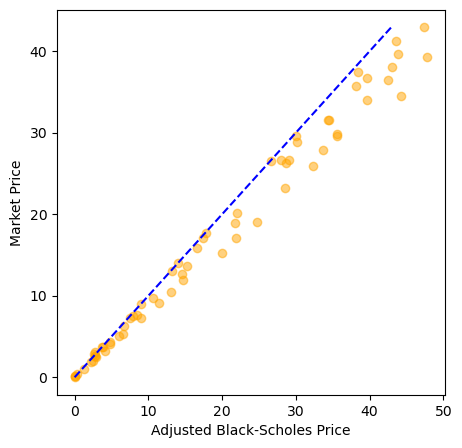

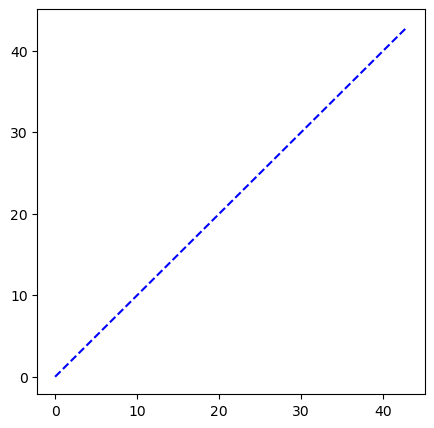

In [17]:
best_model_index = np.argmin(np.mean(amses_meta, axis = 1))
best_model = models_list[best_model_index]
best_features = powerset_candidate_list[np.argmin(np.mean(amses_meta, axis=0))]

model = list(models.items())[best_model_index-1][1]
model.fit(df_train[best_features], df_train['lastPrice'])
model_pred = model.predict(df_test[best_features])
df_test[best_model] = model_pred

# Toggle to show or hide the improved model prediction
show_scatter = True  # Change to False to hide the scatter plot

# Define the interactive function
def plot_with_toggle(show_scatter=True):
    plt.figure(figsize=(5, 5))
    
    # Plot y = x reference line
    x = np.linspace(0, np.max(df_test["lastPrice"]), 100)
    plt.plot(x, x, color='blue', linestyle='--', label='y = x')

    # Conditionally plot improved model prediction
    if show_scatter:
        plt.scatter(df_test[best_model], df_test['lastPrice'], label="Improved Price")

    # Always show the Black-Scholes prediction
    plt.scatter(df_test["bs_price"], df_test["lastPrice"], label="BS Price Prediction", color = "orange", alpha=0.5)

    # Labels and title
    plt.xlabel("Adjusted Black-Scholes Price")
    plt.ylabel("Market Price")
    plt.title("Google Market Price vs Adjusted BS Prediction\nCV MSE: {:.4f}".format(
        mse(df_test["lastPrice"], model_pred)))
    plt.grid(True)
    plt.legend()
    plt.show()

# Create and display the interactive widget
widgets.interact(plot_with_toggle, show_scatter=widgets.Checkbox(value=True, description='Show Improved Price'))


<h2>This is for Apple<h2>

In [18]:
# let us pick the data we want to focus on
#calls =faang_df_clean[(faang_df_clean['option_type']=='call')]

calls = faang_df_clean[(faang_df_clean['ticker']=='AAPL') & (faang_df_clean['optionType']=='call')]

df_train, df_test= train_test_split(calls, test_size=0.2, shuffle=True,random_state=213)


## This array will hold the average mse for each set of features and model
amses_apple = np.zeros((num_models, len(powerset_candidate_list)))

# set a feature counter
k = 0


for subset in powerset_candidate_list:
    #state which features are we using to train the model
    #print("We are now trying to train the model using ", subset)

    kfold = KFold(n_splits = 5, random_state = 213, shuffle = True)

    ## This array will hold the mse for each model and split
    subset_mse = np.zeros((num_models, num_splits))

    ## sets a split counter
    i = 0

    ## Implement time series data split
    num_data = len(calls)
    percent = 0.1
    #kfold_time = TimeSeriesSplit(n_splits = 5, test_size= int(num_data*percent)) 

    ## loop through the kfold here
    for train_index, test_index in kfold.split(df_train):
        ## cv training set
        calls_tt = df_train.iloc[train_index]
        ## cv holdout set
        calls_ho = df_train.iloc[test_index]

        ## Fit and get ho mse for the baseline model (Black-Schole's model)
        subset_mse[0, i] = mse(calls_ho["lastPrice"], calls_ho["bs_price"])

        for model_index, (model_name, model) in enumerate(models.items()):
            model.fit(calls_tt[subset], calls_tt["lastPrice"])
            preds = model.predict(calls_ho[subset])
            mse_val = mse(calls_ho["lastPrice"], preds)

            # Store or print results
            subset_mse[model_index + 1, i] = mse_val

        i += 1

    ## Append the avergae mse to amses
    for j in range(num_models):
        amses_apple[j, k] = np.mean(subset_mse[j,:])
    

    k += 1

evaluate_rmses(amses_apple, "Apple", calls_tt)
    
#here is the code for us to record Apple's performance
all_company_amses["Apple"] = amses_apple[:,np.argmin(np.mean(amses_apple, axis=0))]     

We are looking at Apple based on 205
The features that would produce the lowest mean cv mse are 
 ['bs_price', 'impliedVolatility', 'log_moneyness', 'ask_bid_spread'] 
 and using these features, there is an avg cv mse of 3.178258944203515  across all the models.

Among different models, the model with the best overall performance is Bagging 
In comparison to the Black-Schole's model, it improves the performance by 92.27551741409631 %.


The BS-Model improved the performance by 0.0 %.

The MLR improved the performance by 92.25818085268583 %.

The KNN improved the performance by 79.83631721507848 %.

The Ridge improved the performance by 91.30509068042699 %.

The Lasso improved the performance by 84.74591696845604 %.

The Bagging improved the performance by 92.27551741409631 %.

The XGBoost improved the performance by 88.39433901658597 %.

The Random Forest improved the performance by 80.5061911785128 %.



In [19]:
best_model_index = np.argmin(np.mean(amses_apple, axis = 1))
best_model = models_list[best_model_index]
best_features = powerset_candidate_list[np.argmin(np.mean(amses_apple, axis=0))]

model = list(models.items())[best_model_index-1][1]
model.fit(df_train[best_features], df_train['lastPrice'])
model_pred = model.predict(df_test[best_features])
df_test[best_model] = model_pred

# Toggle to show or hide the improved model prediction
show_scatter = True  # Change to False to hide the scatter plot

# Define the interactive function
def plot_with_toggle(show_scatter=True):
    plt.figure(figsize=(5, 5))
    
    # Plot y = x reference line
    x = np.linspace(0, np.max(df_test["lastPrice"]), 100)
    plt.plot(x, x, color='blue', linestyle='--', label='y = x')

    # Conditionally plot improved model prediction
    if show_scatter:
        plt.scatter(df_test[best_model], df_test['lastPrice'], label="Improved Price")

    # Always show the Black-Scholes prediction
    plt.scatter(df_test["bs_price"], df_test["lastPrice"], label="BS Price Prediction", color = "orange", alpha=0.5)

    # Labels and title
    plt.xlabel("Adjusted Black-Scholes Price")
    plt.ylabel("Market Price")
    plt.title("Google Market Price vs Adjusted BS Prediction\nCV MSE: {:.4f}".format(
        mse(df_test["lastPrice"], model_pred)))
    plt.grid(True)
    plt.legend()
    plt.show()

# Create and display the interactive widget
widgets.interact(plot_with_toggle, show_scatter=widgets.Checkbox(value=True, description='Show Improved Price'))



interactive(children=(Checkbox(value=True, description='Show Improved Price'), Output()), _dom_classes=('widge…

<function __main__.plot_with_toggle(show_scatter=True)>

<h2>This is for Amazon <h2>

In [20]:
# let us pick the data we want to focus on
#calls =faang_df_clean[(faang_df_clean['option_type']=='call')]

calls = faang_df_clean[(faang_df_clean['ticker']=='AMZN') & (faang_df_clean['optionType']=='call')]

df_train, df_test= train_test_split(calls, test_size=0.2, shuffle=True,random_state=213)


## This array will hold the average mse for each set of features and model
amses_amazon = np.zeros((num_models, len(powerset_candidate_list)))

# set a feature counter
k = 0

for subset in powerset_candidate_list:
    #state which features are we using to train the model
    #print("We are now trying to train the model using ", subset)

    kfold = KFold(n_splits = 5, random_state = 213, shuffle = True)

    ## This array will hold the mse for each model and split
    subset_mse = np.zeros((num_models, num_splits))

    ## sets a split counter
    i = 0

    ## Implement time series data split
    num_data = len(calls)
    percent = 0.1
    #kfold_time = TimeSeriesSplit(n_splits = 5, test_size= int(num_data*percent)) 

    ## loop through the kfold here
    for train_index, test_index in kfold.split(df_train):
        ## cv training set
        calls_tt = df_train.iloc[train_index]
        ## cv holdout set
        calls_ho = df_train.iloc[test_index]

        ## Fit and get ho mse for the baseline model (Black-Schole's model)
        subset_mse[0, i] = mse(calls_ho["lastPrice"], calls_ho["bs_price"])

        for model_index, (model_name, model) in enumerate(models.items()):
            model.fit(calls_tt[subset], calls_tt["lastPrice"])
            preds = model.predict(calls_ho[subset])
            mse_val = mse(calls_ho["lastPrice"], preds)

            # Store or print results
            subset_mse[model_index + 1, i] = mse_val
        i += 1

    ## Append the avergae mse to amses
    for j in range(num_models):
        amses_amazon[j, k] = np.mean(subset_mse[j,:])
    

    k += 1

evaluate_rmses(amses_amazon, "Amazon", calls_tt)

#here is the code for us to record Amazon's performance
all_company_amses["Amazon"] = amses_amazon[:,np.argmin(np.mean(amses_amazon, axis=0))]  

We are looking at Amazon based on 221
The features that would produce the lowest mean cv mse are 
 ['bs_price', 'impliedVolatility', 'log_moneyness', 'ask_bid_spread'] 
 and using these features, there is an avg cv mse of 3.0929224308811456  across all the models.

Among different models, the model with the best overall performance is MLR 
In comparison to the Black-Schole's model, it improves the performance by 86.62545369212519 %.


The BS-Model improved the performance by 0.0 %.

The MLR improved the performance by 86.62545369212519 %.

The KNN improved the performance by 69.09582208453784 %.

The Ridge improved the performance by 85.20894907332588 %.

The Lasso improved the performance by 76.77557731728166 %.

The Bagging improved the performance by 86.613462384914 %.

The XGBoost improved the performance by 80.40114322671421 %.

The Random Forest improved the performance by 70.45936275866333 %.



In [21]:
best_model_index = np.argmin(np.mean(amses_amazon, axis = 1))
best_model = models_list[best_model_index]
best_features = powerset_candidate_list[np.argmin(np.mean(amses_amazon, axis=0))]

model = list(models.items())[best_model_index-1][1]
model.fit(df_train[best_features], df_train['lastPrice'])
model_pred = model.predict(df_test[best_features])
df_test[best_model] = model_pred

# Toggle to show or hide the improved model prediction
show_scatter = True  # Change to False to hide the scatter plot

# Define the interactive function
def plot_with_toggle(show_scatter=True):
    plt.figure(figsize=(5, 5))
    
    # Plot y = x reference line
    x = np.linspace(0, np.max(df_test["lastPrice"]), 100)
    plt.plot(x, x, color='blue', linestyle='--', label='y = x')

    # Conditionally plot improved model prediction
    if show_scatter:
        plt.scatter(df_test[best_model], df_test['lastPrice'], label="Improved Price")

    # Always show the Black-Scholes prediction
    plt.scatter(df_test["bs_price"], df_test["lastPrice"], label="BS Price Prediction", color = "orange", alpha=0.5)

    # Labels and title
    plt.xlabel("Adjusted Black-Scholes Price")
    plt.ylabel("Market Price")
    plt.title("Google Market Price vs Adjusted BS Prediction\nCV MSE: {:.4f}".format(
        mse(df_test["lastPrice"], model_pred)))
    plt.grid(True)
    plt.legend()
    plt.show()

# Create and display the interactive widget
widgets.interact(plot_with_toggle, show_scatter=widgets.Checkbox(value=True, description='Show Improved Price'))


interactive(children=(Checkbox(value=True, description='Show Improved Price'), Output()), _dom_classes=('widge…

<function __main__.plot_with_toggle(show_scatter=True)>

<h2> This is for Netflix <h2>

In [22]:
# let us pick the data we want to focus on
#calls =faang_df_clean[(faang_df_clean['option_type']=='call')]

calls = faang_df_clean[(faang_df_clean['ticker']=='NFLX') & (faang_df_clean['optionType']=='call')]

df_train, df_test= train_test_split(calls, test_size=0.2, shuffle=True,random_state=213)

## This array will hold the average mse for each set of features and model
amses_netflix = np.zeros((num_models, len(powerset_candidate_list)))

# set a feature counter
k = 0

for subset in powerset_candidate_list:
    #state which features are we using to train the model
    #print("We are now trying to train the model using ", subset)

    kfold = KFold(n_splits = 5, random_state = 213, shuffle = True)

    ## This array will hold the mse for each model and split
    subset_mse = np.zeros((num_models, num_splits))

    ## sets a split counter
    i = 0

    ## Implement time series data split
    num_data = len(calls)
    percent = 0.1
    #kfold_time = TimeSeriesSplit(n_splits = 5, test_size= int(num_data*percent)) 

    ## loop through the kfold here
    for train_index, test_index in kfold.split(df_train):
        ## cv training set
        calls_tt = df_train.iloc[train_index]
        ## cv holdout set
        calls_ho = df_train.iloc[test_index]

        ## Fit and get ho mse for the baseline model (Black-Schole's model)
        subset_mse[0, i] = mse(calls_ho["lastPrice"], calls_ho["bs_price"])

        for model_index, (model_name, model) in enumerate(models.items()):
            model.fit(calls_tt[subset], calls_tt["lastPrice"])
            preds = model.predict(calls_ho[subset])
            mse_val = mse(calls_ho["lastPrice"], preds)

            # Store or print results
            subset_mse[model_index + 1, i] = mse_val

        i += 1

    ## Append the avergae mse to amses
    for j in range(num_models):
        amses_netflix[j, k] = np.mean(subset_mse[j,:])
    

    k += 1

evaluate_rmses(amses_netflix, "Netflix", calls_tt)
    
#here is the code for us to record Netflix's performance
all_company_amses["Netflix"] = amses_netflix[:,np.argmin(np.mean(amses_netflix, axis=0))]    

We are looking at Netflix based on 469
The features that would produce the lowest mean cv mse are 
 ['bs_price', 'impliedVolatility', 'log_moneyness', 'ask_bid_spread'] 
 and using these features, there is an avg cv mse of 183.59625248192054  across all the models.

Among different models, the model with the best overall performance is MLR 
In comparison to the Black-Schole's model, it improves the performance by 90.236231650496 %.


The BS-Model improved the performance by 0.0 %.

The MLR improved the performance by 90.236231650496 %.

The KNN improved the performance by 86.40369636438629 %.

The Ridge improved the performance by 90.17926211309063 %.

The Lasso improved the performance by 88.47084075708132 %.

The Bagging improved the performance by 90.23490042075227 %.

The XGBoost improved the performance by 89.22931103952583 %.

The Random Forest improved the performance by 88.83359044064294 %.



In [23]:
best_model_index = np.argmin(np.mean(amses_netflix, axis = 1))
best_model = models_list[best_model_index]
best_features = powerset_candidate_list[np.argmin(np.mean(amses_netflix, axis=0))]

model = list(models.items())[best_model_index-1][1]
model.fit(df_train[best_features], df_train['lastPrice'])
model_pred = model.predict(df_test[best_features])
df_test[best_model] = model_pred

# Toggle to show or hide the improved model prediction
show_scatter = True  # Change to False to hide the scatter plot

# Define the interactive function
def plot_with_toggle(show_scatter=True):
    plt.figure(figsize=(5, 5))
    
    # Plot y = x reference line
    x = np.linspace(0, np.max(df_test["lastPrice"]), 100)
    plt.plot(x, x, color='blue', linestyle='--', label='y = x')

    # Always show the Black-Scholes prediction
    plt.scatter(df_test["bs_price"], df_test["lastPrice"], label="BS Price Prediction", color = "orange", alpha=0.5)

    # Conditionally plot improved model prediction
    if show_scatter:
        plt.scatter(df_test[best_model], df_test['lastPrice'], label="Improved Price")

    # Labels and title
    plt.xlabel("Adjusted Black-Scholes Price")
    plt.ylabel("Market Price")
    plt.title("Google Market Price vs Adjusted BS Prediction\nCV MSE: {:.4f}".format(
        mse(df_test["lastPrice"], model_pred)))
    plt.grid(True)
    plt.legend()
    plt.show()

# Create and display the interactive widget
widgets.interact(plot_with_toggle, show_scatter=widgets.Checkbox(value=True, description='Show Improved Price'))

interactive(children=(Checkbox(value=True, description='Show Improved Price'), Output()), _dom_classes=('widge…

<function __main__.plot_with_toggle(show_scatter=True)>

<h2>This is for Google <h2>

In [26]:
#let us pick the data we want to focus on
#calls =faang_df_clean[(faang_df_clean['option_type']=='call')]

calls = faang_df_clean[(faang_df_clean['ticker']=='GOOG') & (faang_df_clean['optionType']=='call')]

df_train, df_test= train_test_split(calls, test_size=0.2, shuffle=True,random_state=213)

## This array will hold the average mse for each set of features and model
amses_google = np.zeros((num_models, len(powerset_candidate_list)))

# set a feature counter
k = 0

for subset in powerset_candidate_list:

    #creating the k-fold splitting
    kfold = KFold(n_splits = 5, random_state = 213, shuffle = True)

    ## This array will hold the mse for each model and split
    subset_mse = np.zeros((num_models, num_splits))

    ## sets a split counter
    i = 0

    ## Implement time series data split
    num_data = len(calls)
    percent = 0.1
    #kfold_time = TimeSeriesSplit(n_splits = 5, test_size= int(num_data*percent)) 

    ## loop through the kfold here
    for train_index, test_index in kfold.split(df_train):
        ## cv training set
        calls_tt = df_train.iloc[train_index]
        ## cv holdout set
        calls_ho = df_train.iloc[test_index]

        ## Fit and get ho mse for the baseline model (Black-Schole's model)
        subset_mse[0, i] = mse(calls_ho["lastPrice"], calls_ho["bs_price"])

        for model_index, (model_name, model) in enumerate(models.items()):
            model.fit(calls_tt[subset], calls_tt["lastPrice"])
            preds = model.predict(calls_ho[subset])
            mse_val = mse(calls_ho["lastPrice"], preds)

            # Store or print results
            subset_mse[model_index + 1, i] = mse_val

        i += 1

    ## Append the avergae mse to amses
    for j in range(num_models):
        amses_google[j, k] = np.mean(subset_mse[j,:])
    

    k += 1

evaluate_rmses(amses_google, "Google", calls_tt)
    
#here is the code for us to record Google's performance
all_company_amses["Google"] = amses_google[:,np.argmin(np.mean(amses_google, axis=0))] 


We are looking at Google based on 173
The features that would produce the lowest mean cv mse are 
 ['bs_price', 'impliedVolatility', 'log_moneyness', 'ask_bid_spread'] 
 and using these features, there is an avg cv mse of 3.761666176294359  across all the models.

Among different models, the model with the best overall performance is Bagging 
In comparison to the Black-Schole's model, it improves the performance by 77.58446730798234 %.


The BS-Model improved the performance by 0.0 %.

The MLR improved the performance by 77.55052789700201 %.

The KNN improved the performance by 67.40491613118556 %.

The Ridge improved the performance by 76.92274080137709 %.

The Lasso improved the performance by 72.85028157949847 %.

The Bagging improved the performance by 77.58446730798234 %.

The XGBoost improved the performance by 65.02183600093058 %.

The Random Forest improved the performance by 65.3986283668567 %.



In [28]:
best_model_index = np.argmin(np.mean(amses_google, axis = 1))
best_model = models_list[best_model_index]
best_features = powerset_candidate_list[np.argmin(np.mean(amses_google, axis=0))]

model = list(models.items())[best_model_index-1][1]
model.fit(df_train[best_features], df_train['lastPrice'])
model_pred = model.predict(df_test[best_features])
df_test[best_model] = model_pred

# Toggle to show or hide the improved model prediction
show_scatter = True  # Change to False to hide the scatter plot

# Define the interactive function
def plot_with_toggle(show_scatter=True):
    plt.figure(figsize=(5, 5))
    
    # Plot y = x reference line
    x = np.linspace(0, np.max(df_test["lastPrice"]), 100)
    plt.plot(x, x, color='blue', linestyle='--', label='y = x')

    # Conditionally plot improved model prediction
    if show_scatter:
        plt.scatter(df_test[best_model], df_test['lastPrice'], label="Improved Price")

    # Always show the Black-Scholes prediction
    plt.scatter(df_test["bs_price"], df_test["lastPrice"], label="BS Price Prediction", color = "orange", alpha=0.5)

    # Labels and title
    plt.xlabel("Adjusted Black-Scholes Price")
    plt.ylabel("Market Price")
    plt.title("Google Market Price vs Adjusted BS Prediction\nCV MSE: {:.4f}".format(
        mse(df_test["lastPrice"], model_pred)))
    plt.grid(True)
    plt.legend()
    plt.show()

# Create and display the interactive widget
widgets.interact(plot_with_toggle, show_scatter=widgets.Checkbox(value=True, description='Show Improved Price'))


interactive(children=(Checkbox(value=True, description='Show Improved Price'), Output()), _dom_classes=('widge…

<function __main__.plot_with_toggle(show_scatter=True)>

The plot I generated shows, for each company, the mean squared error (MSE) between the predicted option prices from each model and the observed lastPrice. Note that the MSEs in the plot are not the actual values — I applied a scaling factor to make the Black-Scholes model's price the same across all companies and scaled the predictions from all other models by the same factor. This allows for a more intuitive visual comparison of the relative improvement each model achieves, as reflected by the reduction in bar height.

In [29]:
#standardized all bs model MSE
for i in range(all_company_amses.shape[1]-1):
    coef = float(all_company_amses.iloc[0, 0]/all_company_amses.iloc[0, i+1])
    for j in range(all_company_amses.shape[0]):
        all_company_amses.iloc[j, i+1] *= coef


Read the explanation above to correctly interpret the graph.


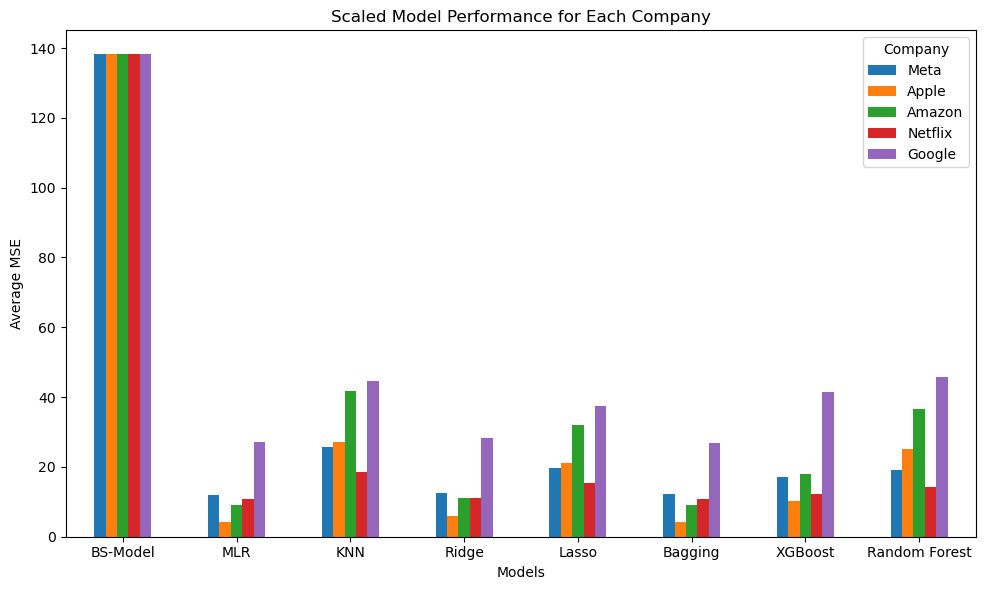

In [30]:
# Plot the bar chart for comparing model efficiency
all_company_amses.plot(kind='bar', figsize=(10, 6))

print("Read the explanation above to correctly interpret the graph.")
plt.title('Scaled Model Performance for Each Company')
plt.ylabel('Average MSE')  # or any performance metric you're using
plt.xlabel('Models')
plt.xticks(rotation=0)
plt.legend(title='Company')
plt.tight_layout()
plt.show()

Improvement for all companies.

In [32]:
# let us pick the data we want to focus on
#calls =faang_df_clean[(faang_df_clean['option_type']=='call')]

calls = faang_df_clean[(faang_df_clean['optionType']=='call')]

df_train, df_test= train_test_split(calls, test_size=0.2, shuffle=True,random_state=213)

## This array will hold the average mse for each set of features and model
amses = np.zeros((num_models, len(powerset_candidate_list)))

# set a feature counter
k = 0

for subset in powerset_candidate_list:
    #state which features are we using to train the model
    #print("We are now trying to train the model using ", subset)

    kfold = KFold(n_splits = 5, shuffle = True, random_state = 213)

    ## This array will hold the mse for each model and split
    rmses = np.zeros((num_models, num_splits))

    ## sets a split counter
    i = 0

    ## Implement time series data split
    num_data = len(calls)
    percent = 0.1
    #kfold_time = TimeSeriesSplit(n_splits = 5, test_size= int(num_data*percent)) 

    ## loop through the kfold here
    for train_index, test_index in kfold.split(df_train):
        ## cv training set
        calls_tt = df_train.iloc[train_index]
        ## cv holdout set
        calls_ho = df_train.iloc[test_index]

        ## Fit and get ho mse for the baseline model (Black-Schole's model)
        rmses[0, i] = mse(calls_ho["lastPrice"], calls_ho["bs_price"])

        for model_index, (model_name, model) in enumerate(models.items()):
            model.fit(calls_tt[subset], calls_tt["lastPrice"])
            preds = model.predict(calls_ho[subset])
            mse_val = mse(calls_ho["lastPrice"], preds)

            # Store or print results
            rmses[model_index + 1, i] = mse_val


        i += 1

    ## Append the avergae mse to amses
    for j in range(num_models):
        amses[j, k] = np.mean(rmses[j,:])
    k += 1

# Find the avg cv mse for each subset of features here
print("We are looking at all companies based on", calls_tt.shape[0], "data.")
print("The features that would produce the lowest mean cv mse are \n", 
    powerset_candidate_list[np.argmin(np.mean(amses, axis=0))],
    "\n and using these features, there is an avg cv mse of",
    np.mean(amses, axis=0)[np.argmin(np.mean(amses, axis=0))], 
    " across all the models.\n")

print("Among different models, the model with the best overall performance is", 
    models_list[np.argmin(np.mean(amses, axis = 1))], 
    "\nIn comparison to the Black-Schole's model, it improves the performance by", 
    float((np.mean(amses, axis=1)[0] - np.mean(amses, axis=1)[np.argmin(np.mean(amses, axis=1))])/np.mean(amses, axis=1)[0]) * 100, "%.\n")

print()
# This code will print the improvement by each model
for model in range(len(models_list)):
    print("The", models_list[model], "improved the performance by", 
        float((np.mean(amses[0,:])- np.mean(amses[model,:]))/
                                            np.mean(amses[0, :])) * 100, "%.\n")


We are looking at all companies based on 1568 data.
The features that would produce the lowest mean cv mse are 
 ['bs_price', 'impliedVolatility', 'log_moneyness', 'ask_bid_spread'] 
 and using these features, there is an avg cv mse of 64.83064335551914  across all the models.

Among different models, the model with the best overall performance is MLR 
In comparison to the Black-Schole's model, it improves the performance by 88.79638836320602 %.


The BS-Model improved the performance by 0.0 %.

The MLR improved the performance by 88.79638836320602 %.

The KNN improved the performance by 85.66009693106416 %.

The Ridge improved the performance by 88.79088397907641 %.

The Lasso improved the performance by 87.11129313138758 %.

The Bagging improved the performance by 88.79233264193253 %.

The XGBoost improved the performance by 88.13535490775935 %.

The Random Forest improved the performance by 87.9592414845768 %.

